In [1]:
import warnings
warnings.filterwarnings('ignore')
from popsycle import synthetic
from popsycle import utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units
from scipy.optimize import curve_fit

from selectionfunctions.source import Source as Source_sf
from selectionfunctions import cog_ii

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.table import Table

import pickle
import h5py

import os

## Galaxia

In [2]:
date = '20230402a/out'
longitude = 15 # l
latitude = 0 # b
area = 0.016

In [3]:
synthetic.write_galaxia_params(output_root = f'./Simulations/{date}',
                               longitude = longitude, # in deg
                               latitude = latitude, # in deg
                               area = area)     # in deg^2 # a whole sphere has a solid angle of approx 41253 deg^2

** Generating ./Simulations/20230402a/out_galaxia_params.txt **
-- outputFile ./Simulations/20230402a/out
-- outputDir ./
-- photoSys UBV
-- magcolorNames V,B-V
-- appMagLimits[0] -1000
-- appMagLimits[1] 1000.000000
-- absMagLimits[0] -1000
-- absMagLimits[1] 1000
-- colorLimits[0] -1000
-- colorLimits[1] 1000
-- geometryOption 1
-- longitude 15.000000
-- latitude 0.000000
-- surveyArea 0.01600
-- fSample 1.000000
-- popID -1
-- warpFlareOn 1
-- seed 5
-- r_max 30
-- starType 0
-- photoError 0


In [4]:
synthetic.run_galaxia(output_root = f'./Simulations/{date}',
                      longitude = longitude,
                      latitude = latitude,
                      area = area,
                      galaxia_galaxy_model_filename = f'./Simulations/galaxyModelParams_PopSyCLEv2.txt')

** Executing Galaxia with ./Simulations/20230402a/out_galaxia_params.txt and ./Simulations/galaxyModelParams_PopSyCLEv2.txt **
** STDOUT **
Reading Parameter file-             ./Simulations/galaxyModelParams_PopSyCLEv2.txt
--------------------------------------------------------
GalaxiaData              /home/penguin/Desktop/IITB/Research/Microlensing/Packages/GalaxiaData
bulge_Rc                 2.54                    
bulge_x0                 1.59                    
bulge_y0                 0.424                   
bulge_z0                 0.424                   
bulge_alpha              78.9                    
bulge_beta               3.5                     
bulge_gamma              91.3                    
bulge_sigma_r            100                     
bulge_sigma_phi          100                     
bulge_sigma_z            100                     
bulge_patternspeed       40.00                   
--------------------------------------------------------
inputDir = /home/p

## Population Synthesis

Black hole and neutron star kick speeds

In [5]:
synthetic.perform_pop_syn(ebf_file = f'./Simulations/{date}.ebf', 
                          output_root = f'./Simulations/{date}',
                          iso_dir = '/home/penguin/Desktop/IITB/Research/Microlensing/Packages/GalaxiaData/Isochrones',
                          bin_edges_number = None, 
                          BH_kick_speed_mean = 100, 
                          NS_kick_speed_mean = 350);

*********************** Starting popid 0
Starting age bin  5.0100998878479
Starting sub-bin  0
Found 40 stars out of mass range
Starting age bin  6.3
Starting sub-bin  0
Found 318 stars out of mass range
Starting age bin  7.0
Starting sub-bin  0
Found 1294 stars out of mass range
Starting age bin  7.7
Starting sub-bin  0
Found 1701 stars out of mass range
Starting age bin  8.0
Starting sub-bin  0
Found 1685 stars out of mass range
*********************** Starting popid 1
Starting age bin  8.176095962524414
Starting sub-bin  0
Found 415 stars out of mass range
Starting age bin  8.384321733236312
Starting sub-bin  0
Found 791 stars out of mass range
Starting age bin  8.59254750394821
Starting sub-bin  0
Starting age bin  8.80077327466011
Starting sub-bin  0
Found 6508 stars out of mass range
*********************** Starting popid 2
Starting age bin  9.000000953674316
Starting sub-bin  0
Found 740 stars out of mass range
Starting age bin  9.077583512544631
Starting sub-bin  0
Found 2037 s

## Gaia Modifiers

In [6]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

# Cone search is more appropriate
coord = SkyCoord(l=longitude, b=latitude, unit=(u.degree, u.degree), frame='galactic')
radius = u.Quantity(0.018 * np.sqrt(area*1e3), u.deg)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


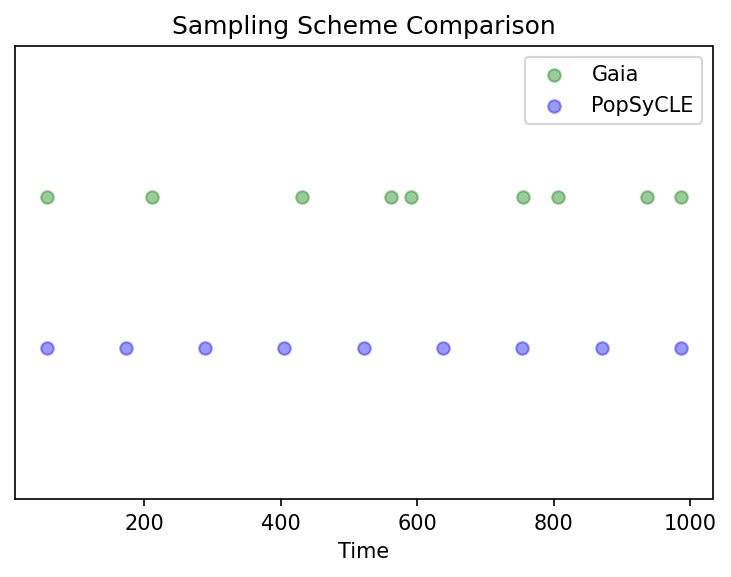

In [7]:
# Code to calculate sampling times

def calc_sl_times():
    with open('./scantimes_l1000_b500.pickle', 'rb') as handle:
        scantimes = pickle.load(handle)

    stimes = np.array(scantimes['times'])
    stimes.dtype, np.shape(stimes), np.min(np.min(stimes)), np.max(np.max(stimes))

    li = int((longitude + 180) * 1000/360)
    bi = int((latitude + 90) * 500/180)

    input_time_array = np.array(stimes[1,bi,li]) - np.min(np.min(stimes))

    n_obs = np.size(input_time_array)
    time_array_pop = np.linspace(input_time_array[0], input_time_array[-1], n_obs)

    plt.figure(dpi=150)
    plt.title('Sampling Scheme Comparison')
    plt.scatter(input_time_array, np.ones(n_obs)+1, alpha=0.4, label='Gaia', color='green')
    plt.scatter(time_array_pop, np.ones(n_obs), alpha=0.4, label='PopSyCLE', color='blue')
    plt.xlabel('Time')
    plt.ylim([0,3])
    #plt.xlim(left=0)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    plt.legend()
    #plt.savefig('./img/sampschemecomp.png', bbox_inches='tight')
    plt.show()

    return input_time_array

input_time_array = calc_sl_times()

In [9]:
def del_galaxia_hf(arr):
    todelete = np.where(arr['rem_id'] == 0)[0]
    arr = np.delete(arr, todelete, axis=0)
    return arr

# np.sort(r[~np.isnan(r['distance_gspphot'])]['distance_gspphot']/1e3)
# Radial distance = np.random.normal(np.mean(arr['rad']), np.std('rad'))
# Same as above for pmra and pmdec and radial_velocity
# For magnitude, set default to 21
def distribute_hf(arr_old, arr, r, startid):
    exbv = np.nanmean(arr_old['exbv']) * np.ones(len(r))
    remnant = np.zeros(len(r))
    appmag = arr_old['ubv_V'] + 5 * np.log10(100 * arr_old['rad']) + arr_old['exbv'] * 2.742
    maglim = 22
    indices = np.where(appmag < maglim)[0]
    
    idx = np.where(r['distance_gspphot'].filled(fill_value=-1) == -1)[0]
    r['distance_gspphot'][idx] = np.random.normal(np.nanmean(arr_old['rad'][indices]), 
                                                  np.nanstd(arr_old['rad'][indices]), 
                                                  len(idx)) * 1e3
    remnant[idx] += 1
    # print(r['distance_gspphot'])
    idx = np.where(r['phot_g_mean_mag'].filled(fill_value=-10) == -10)[0]
    r['phot_g_mean_mag'][idx] = 21
    remnant[idx] += 2
    
    idx = np.where(r['radial_velocity'].filled(fill_value=1000) == 1000)[0]
    r['radial_velocity'][idx] = np.random.normal(np.nanmean(arr_old[indices]['vr']), 
                                                 np.nanstd(arr_old[indices]['vr']), 
                                                 len(idx))
    remnant[idx] += 4

    idx = np.where(r['pmra'].filled(fill_value=1000) == 1000)[0]
    r['pmra'][idx] = np.random.normal(np.nanmean(arr_old[indices]['mu_b']), 
                                      np.nanstd(arr_old[indices]['mu_b']), 
                                      len(idx))
    remnant[idx] += 8
    idx = np.where(r['pmdec'].filled(fill_value=1000) == 1000)[0]
    r['pmdec'][idx] = np.random.normal(np.nanmean(arr_old[indices]['mu_lcosb']), 
                                       np.nanstd(arr_old[indices]['mu_lcosb']), 
                                       len(idx))
    remnant[idx] += 16
    
    objid = np.arange(len(r)) + startid
    ubv = r['phot_g_mean_mag'] - 5 * np.log10(100 * r['distance_gspphot']/1e3) - exbv * 2.742 # Distance is originally in pc
    # extinction is zero for stars infront of galactic centre
    idx = np.where(r['distance_gspphot']/1e3 < 7)[0]
    if (len(idx) != 0):
        ubv[idx] = r['phot_g_mean_mag'][idx] - 5 * np.log10(100 * r['distance_gspphot'][idx]/1e3)
        exbv[idx] = 0
    startid += len(r)

    # Array of stars to be binned to hdf5
    star_dict = {}
    star_dict['zams_mass'] = np.ones(len(r))
    star_dict['mass'] = np.ones(len(r))
    star_dict['px'] = np.zeros(len(r))
    star_dict['py'] = np.zeros(len(r))
    star_dict['pz'] = np.zeros(len(r))
    star_dict['vx'] = np.zeros(len(r))
    star_dict['vy'] = np.zeros(len(r))
    star_dict['vz'] = np.zeros(len(r))
    star_dict['age'] = 11 * np.ones(len(r))
    star_dict['popid'] = np.zeros(len(r))
    star_dict['exbv'] = exbv
    star_dict['glat'] = np.array(r['b'])
    star_dict['glon'] = np.array(r['l'])
    star_dict['mbol'] = -5 * np.ones(len(r))
    star_dict['grav'] = 6 * np.ones(len(r))
    star_dict['teff'] = 3 * np.ones(len(r))
    star_dict['feh'] = 2 * np.ones(len(r))
    star_dict['rad'] = np.array(r['distance_gspphot']) / 1e3
    star_dict['rem_id'] = remnant
    star_dict['obj_id'] = objid
    star_dict['ubv_J'] = np.array(ubv)
    star_dict['ubv_H'] = np.array(ubv)
    star_dict['ubv_K'] = np.array(ubv)
    star_dict['ubv_U'] = np.array(ubv)
    star_dict['ubv_I'] = np.array(ubv)
    star_dict['ubv_B'] = np.array(ubv)
    star_dict['ubv_V'] = np.array(ubv)
    star_dict['ubv_R'] = np.array(ubv)
    star_dict['vr'] = np.array(r['radial_velocity'])
    star_dict['mu_b'] = np.array([r['pmra']])
    star_dict['mu_lcosb'] = np.array([r['pmdec']])

    # Numpy datatype with all of the keys of star_dict
    comp_dtype_arr = []
    for key in star_dict:
        if key in ['rem_id', 'popid']:  # int16 (up to 32767)
            d = (key, 'i2')
        elif key in ['obj_id']:  # int32 (up to 2147483647)
            d = (key, 'i4')
        else:
            d = (key, 'f8')  # float64
        comp_dtype_arr.append(d)
    comp_dtype = np.dtype(comp_dtype_arr)
    
    save_data = np.empty(len(r) + len(arr), dtype=comp_dtype)
    for colname in star_dict:
        save_data[colname][:len(r)] = star_dict[colname]
    for colname in star_dict:
        save_data[colname][len(r):] = arr[colname]

    del star_dict

    return save_data, startid

In [10]:
def create_hfmod(startid, r):
    if (os.path.isfile(f'./Simulations/{date}mod.h5')):
        print('Filename already exists!')
        return

    tab = Table.read(f'./Simulations/{date}_label.fits')
    hf = h5py.File(f'./Simulations/{date}.h5', 'r')
    hfmod = h5py.File(f'./Simulations/{date}mod.h5', 'w')

    hfmod.create_dataset('galaxyModelFile', data=hf['galaxyModelFile'])

    #for namelb in tab['file_name'].data:
    for ll in range(len(hf['long_bin_edges']) - 1):
        for bb in range(len(hf['lat_bin_edges']) - 1):
            namelb = f'l{ll}b{bb}'
            arr_all = np.array(hf[namelb])
            arr_comp = del_galaxia_hf(arr_all)
            idx_loc = ((r['b'] <  hf['lat_bin_edges'][bb + 1]) & 
                       (r['b'] >= hf['lat_bin_edges'][bb]) &
                       (r['l'] <  hf['long_bin_edges'][ll + 1]) &
                       (r['l'] >= hf['long_bin_edges'][ll]))
            load_hfmod, startid = distribute_hf(arr_old=arr_all, arr=arr_comp, r=r[idx_loc], startid=startid)
            hfmod.create_dataset(namelb, data=load_hfmod)

    # namelb = 'l0b0'
    # arr_all = np.array(hf[namelb])
    # arr_comp = del_galaxia_hf(arr_all)
    # idx_loc = (r['b'] < latitude) & (r['l'] < longitude)
    # load_hfmod, startid = distribute_hf(arr_old=arr_all, arr=arr_comp, r=r[idx_loc], startid=startid)
    # hfmod.create_dataset(namelb, data=load_hfmod)

    # namelb = 'l0b1'
    # arr_all = np.array(hf[namelb])
    # arr_comp = del_galaxia_hf(arr_all)
    # idx_loc = (r['b'] > latitude) & (r['l'] < longitude) # Fixed
    # load_hfmod, startid = distribute_hf(arr_old=arr_all, arr=arr_comp, r=r[idx_loc], startid=startid)
    # hfmod.create_dataset(namelb, data=load_hfmod)

    # namelb = 'l1b0'
    # arr_all = np.array(hf[namelb])
    # arr_comp = del_galaxia_hf(arr_all)
    # idx_loc = (r['b'] < latitude) & (r['l'] > longitude) # Fixed
    # load_hfmod, startid = distribute_hf(arr_old=arr_all, arr=arr_comp, r=r[idx_loc], startid=startid)
    # hfmod.create_dataset(namelb, data=load_hfmod)

    # namelb = 'l1b1'
    # arr_all = np.array(hf[namelb])
    # arr_comp = del_galaxia_hf(arr_all)
    # idx_loc = (r['b'] > latitude) & (r['l'] > longitude)
    # load_hfmod, startid = distribute_hf(arr_old=arr_all, arr=arr_comp, r=r[idx_loc], startid=startid)
    # hfmod.create_dataset(namelb, data=load_hfmod)

    hfmod.create_dataset('lat_bin_edges', data=hf['lat_bin_edges'])
    hfmod.create_dataset('long_bin_edges', data=hf['long_bin_edges'])

    hfmod.close()
    hf.close()

In [11]:
create_hfmod(startid=3100000, r=r)

In [9]:
herelb = 'l0b6'
taxarr = np.array(h5py.File(f'./Simulations/{date}.h5', 'r')[herelb])
gyp = taxarr['ubv_V'] + 5 * np.log10(100 * taxarr['rad']) + taxarr['exbv'] * 2.742
romarr = np.array(h5py.File(f'./Simulations/{date}mod.h5', 'r')[herelb])

In [31]:
# romarr2, _ = distribute_hf(arr_old=taxarr, arr=del_galaxia_hf(taxarr), r=r[idx_loc], startid=12000986)

In [12]:
tab = Table.read(f'./Simulations/{date}_label.fits')

for herelb in tab['file_name'].data:
    romarr = np.array(h5py.File(f'./Simulations/{date}mod.h5', 'r')[herelb])
    print(f'{herelb}')
    print(any(np.isnan(romarr['age'])))
    print(any(np.isnan(romarr['popid'])))
    print(any(np.isnan(romarr['exbv'])))
    print(any(np.isnan(romarr['glat']))) 
    print(any(np.isnan(romarr['glon'])))
    print(any(np.isnan(romarr['rad'])))
    print(any(np.isnan(romarr['rem_id'])))
    print(any(np.isnan(romarr['obj_id'])))
    print(any(np.isnan(romarr['vr']))) 
    print(any(np.isnan(romarr['mu_b']))) 
    print(any(np.isnan(romarr['mu_lcosb'])))
    print('===================================')

b'l0b0'
False
False
False
False
False
False
False
False
False
False
False
b'l0b1'
False
False
True
False
False
True
False
False
True
True
True
b'l0b2'
False
False
True
False
False
False
False
False
False
False
False
b'l0b3'
False
False
True
False
False
False
False
False
False
False
False
b'l0b4'
False
False
True
False
False
False
False
False
False
False
False
b'l0b5'
False
False
True
False
False
False
False
False
False
False
False
b'l0b6'
False
False
True
False
False
False
False
False
False
False
False
b'l0b7'
False
False
False
False
False
False
False
False
False
False
False
b'l1b0'
False
False
True
False
False
False
False
False
False
False
False
b'l1b1'
False
False
True
False
False
False
False
False
False
False
False
b'l1b2'
False
False
True
False
False
False
False
False
False
False
False
b'l1b3'
False
False
True
False
False
False
False
False
False
False
False
b'l1b4'
False
False
True
False
False
False
False
False
False
False
False
b'l1b5'
False
False
True
False
False
False
False
Fals

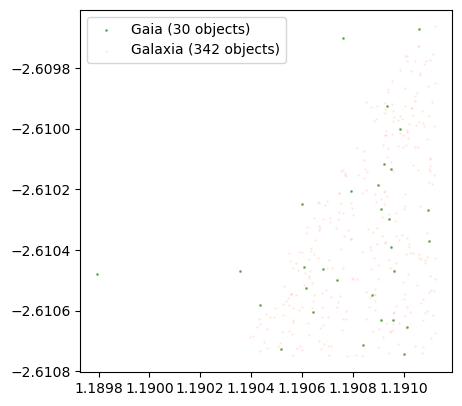

In [10]:
plt.figure(figsize=(4.8,4.8), dpi=100)
plt.scatter(romarr['glon'], romarr['glat'], s=1, alpha=0.5, c='g', label=f'Gaia ({len(romarr)} objects)')
plt.scatter(taxarr['glon'], taxarr['glat'], s=1, alpha=0.1, c='coral', label=f'Galaxia ({len(taxarr)} objects)')
plt.legend()
plt.show()

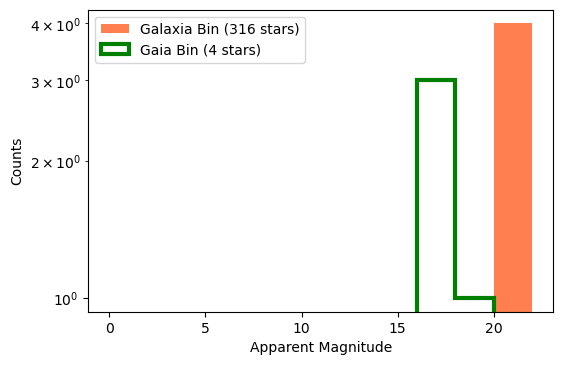

In [11]:
plt.figure(dpi=100)
bins = np.linspace(0,22,12)
# plt.hist(r['phot_g_mean_mag'], bins=bins, histtype='step', color='limegreen', lw=3, label='Gaia Complete')
plt.yscale('log')
arrsize = np.sum(~np.isnan(taxarr['ubv_V']))
plt.hist(taxarr['ubv_V'] + 5 * np.log10(100 * taxarr['rad']) + taxarr['exbv'] * 2.742, bins=bins, 
         color='coral', label=f'Galaxia Bin ({arrsize} stars)')
arrsize = np.sum(~np.isnan(romarr['ubv_V']))
plt.hist(romarr['ubv_V'] + 5 * np.log10(100 * romarr['rad']) + romarr['exbv'] * 2.742, bins=bins, alpha=1, histtype='step',
         color='g', lw=3, label=f'Gaia Bin ({arrsize} stars)')
plt.legend(loc='upper left')
plt.xlabel('Apparent Magnitude')
plt.ylabel('Counts')
plt.show()

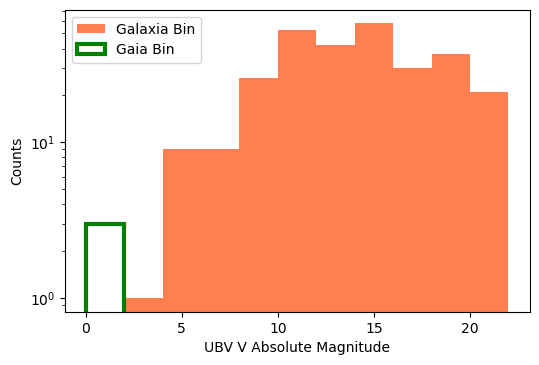

In [12]:
plt.figure(dpi=100)
bins = np.linspace(0,22,12)
# plt.hist(r['phot_g_mean_mag'], bins=bins, histtype='step', color='limegreen', lw=3, label='Gaia Complete')
plt.yscale('log')
plt.hist(taxarr['ubv_V'], bins=bins, color='coral', label='Galaxia Bin')
plt.hist(romarr['ubv_V'], bins=bins, alpha=1, histtype='step', color='g', lw=3, label=f'Gaia Bin')
plt.legend(loc='upper left')
plt.xlabel('UBV V Absolute Magnitude')
plt.ylabel('Counts')
plt.show()

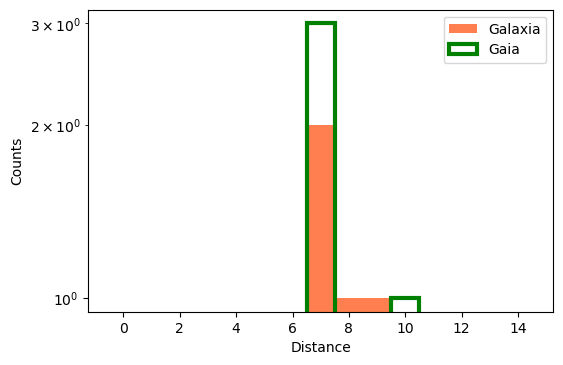

In [13]:
plt.figure(dpi=100)
plt.hist((taxarr[np.where(gyp < 22)[0]])['rad'], bins=np.arange(16)-0.5, color='coral', label='Galaxia')
plt.hist(romarr['rad'][np.where(romarr['rem_id']<100)[0]], bins=np.arange(16)-0.5, histtype='step', color='g', label='Gaia', lw=3)
plt.yscale('log')
plt.xlabel('Distance')
plt.ylabel('Counts')
plt.legend()
plt.show()

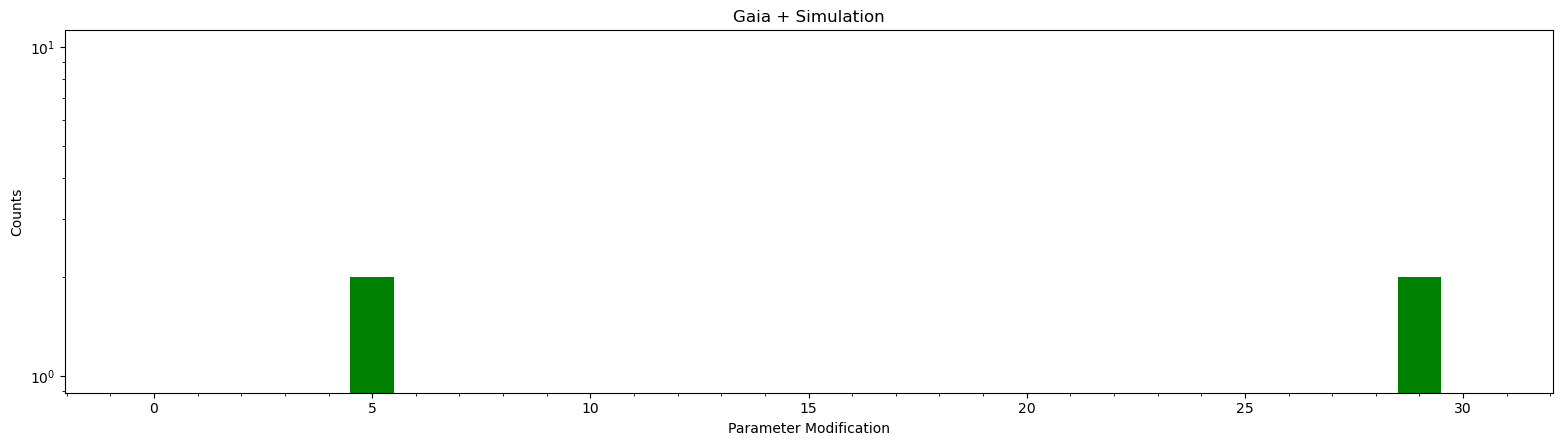

In [14]:
plt.figure(figsize=(19.2,4.8),dpi=100)
plt.hist(romarr['rem_id'], bins=np.arange(32)-0.5, color='g')
plt.minorticks_on()
plt.xlabel('Parameter Modification')
plt.title('Gaia + Simulation')
plt.ylabel('Counts')
plt.yscale('log')
plt.show()

In [15]:
synthetic.calc_events(hdf5_file = f'./Simulations/{date}mod.h5', 
                      output_root2 = f'./Simulations/{date}mod', 
                      radius_cut = 2, 
                      obs_time = 1000, # Ideally set it to input_time_array[-1] ~ 1095 days for eDR3
                      n_obs = 11, 
                      input_time_array = input_time_array,
                      theta_frac = 2, 
                      blend_rad = 0.65, 
                      overwrite = False, 
                      n_proc = 4)

Working on loop ll, bb = Working on loop ll, bb = Working on loop ll, bb = Working on loop ll, bb =    1  110
  050 
4

Working on loop ll, bb =  0 1
Working on loop ll, bb =  0 2
Working on loop ll, bb =  0 5
Working on loop ll, bb =  1 2
Working on loop ll, bb =  1 6
Working on loop ll, bb =  0 6
Working on loop ll, bb =  1 0
Working on loop ll, bb =  0 3
Working on loop ll, bb =  2 0
Working on loop ll, bb =  2 2
Working on loop ll, bb =  1 3
Working on loop ll, bb =  2 6
Working on loop ll, bb =  2 1
Working on loop ll, bb =  3 0
Working on loop ll, bb =  2 3
Working on loop ll, bb =  1 4
Working on loop ll, bb =  3 3
Working on loop ll, bb =  3 1
Working on loop ll, bb =  2 4
Working on loop ll, bb =  4 0
Working on loop ll, bb =  3 4
Working on loop ll, bb =  3 2
Working on loop ll, bb =  4 1
Working on loop ll, bb =  2 5
Working on loop ll, bb =  4 4
Working on loop ll, bb =  3 5
Working on loop ll, bb =  4 2
Working on loop ll, bb =  5 1
Working on loop ll, bb =  4 3
Working on

In [16]:
event_tab = Table.read(f'./Simulations/{date}_events.fits')
event_tab_mod = Table.read(f'./Simulations/{date}mod_events.fits')
event_tab_mod

zams_mass_L,mass_L,px_L,py_L,pz_L,vx_L,vy_L,vz_L,age_L,popid_L,exbv_L,glat_L,glon_L,mbol_L,grav_L,teff_L,feh_L,rad_L,rem_id_L,obj_id_L,ubv_J_L,ubv_H_L,ubv_K_L,ubv_U_L,ubv_I_L,ubv_B_L,ubv_V_L,ubv_R_L,vr_L,mu_b_L,mu_lcosb_L,zams_mass_S,mass_S,px_S,py_S,pz_S,vx_S,vy_S,vz_S,age_S,popid_S,exbv_S,glat_S,glon_S,mbol_S,grav_S,teff_S,feh_S,rad_S,rem_id_S,obj_id_S,ubv_J_S,ubv_H_S,ubv_K_S,ubv_U_S,ubv_I_S,ubv_B_S,ubv_V_S,ubv_R_S,vr_S,mu_b_S,mu_lcosb_S,theta_E,u0,mu_rel,t0
float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
6.090955375054409,1.0579141358809308,5.051454831258758,0.10831651811523092,-0.23151650164549095,73.87716408032952,-77.54491420014487,-33.79262457376808,9.621837320923804,4,--,-2.623474271445513,1.2283676808991981,--,--,--,--,5.057898357340056,101,10667037,--,--,--,--,--,--,--,--,73.66887630360712,-1.2691498264177536,-3.297126471114974,1.6787078900445886,0.5769791600148602,8.4813379105238,0.18186280135550528,-0.3887104888317434,-219.53098197937877,-284.86514336010447,-47.16186250970632,10.0,9,--,-2.6234737953263316,1.2283698319130065,--,--,--,--,8.49214258151365,101,11256749,--,--,--,--,--,--,--,--,-223.19220554419604,-1.4257465301428542,-6.952774511136853,0.8288805239445807,1.6691021495445202,3.659000563013535,786.3832873413019
6.125886417808038,1.0617216195410761,3.44115147523193,0.07254253662942015,-0.15645148924353086,18.61466971540697,69.09344893736376,-28.813079473555653,9.835446158766747,5,--,-2.6025710360419962,1.2076432981183836,--,--,--,--,3.4454899316111276,101,10687085,--,--,--,--,--,--,--,--,21.354361661119754,-1.705225722977828,4.202328597167882,1.9393172016713562,0.6053855749821778,8.28265117098703,0.174606311096598,-0.37656260378059236,-219.20773649892524,-293.61719837207517,227.21426705952814,10.0,9,--,-2.6025722875041293,1.2076445353389085,--,--,--,--,8.293088686317207,101,11072041,--,--,--,--,--,--,--,--,-235.4321271455921,5.509441020741826,-7.344301569172084,1.2095668395858283,1.39525472847349,13.615288627905267,187.8371461037193
1.175433171672232,0.5221222157122734,7.855007744295712,0.16470645261092634,-0.369478094869212,439.1148434544162,72.75462472127036,72.00053084268463,10.04139232635498,7,--,-2.692469620203235,1.2012406331835148,--,--,--,--,7.865460528991269,101,10715910,--,--,--,--,--,--,--,--,436.6750203154494,2.4821805638447647,1.7027768513973482,4.116532534154611,0.8427020462228525,13.760695497418748,0.288556167442183,-0.6472736969482741,63.952875868086274,-458.638068580554,-22.407525922977996,9.506064546704291,4,--,-2.6924687209602953,1.2012433744086795,--,--,--,--,13.77894102153475,101,10663690,--,--,--,--,--,--,--,--,55.31653917799394,-0.3033495967303355,-7.035521555891107,0.4810414538527021,1.905448157409645,9.171534077257386,376.8559328404915
3.337801255274097,0.7578203368248766,3.5130956234075104,0.07946310028348753,-0.16055909715199973,-57.388586549095926,3.8078402588881874,-89.73557899464333,10.04139232635498,7,--,-2.616128554547945,1.2957376882964626,--,--,--,--,3.5176111075360574,101,10727859,--,--,--,--,--,--,--,--,-53.132219004579916,-5.528716833898694,0.30586788153479516,4.659065099683671,0.9018380958655202,8.40125509338602,0.19001967364778055,-0.3839665320459826,-104.43743870158484,-461.4874510515289,97.33172620167821,10.0,9,--,-2.616133963609891,1.2957452241487117,--,--,--,--,8.412187165160228,101,11286401,--,--,--,--,--,--,--,--,-119.16932348649408,2.305161191126527,-11.502270458527454,1.0090371633368067,1.8580781135241677,14.170454331778537,895.7102344199632
42.84554628396233,15.005051714234725,5.945261393872788,0.13653

In [32]:
np.sort(romarr[romarr['rem_id'] == 101]['rad'])[-10:], np.sort(taxarr[taxarr['rem_id'] == 101]['rad'])[-10:]

(array([28.98353157, 29.02699634, 29.09234172, 29.09252778, 29.10631061,
        29.11690486, 29.29223383, 29.71883972, 29.72786665, 29.92656023]),
 array([28.98353157, 29.02699634, 29.09234172, 29.09252778, 29.10631061,
        29.11690486, 29.29223383, 29.71883972, 29.72786665, 29.92656023]))

In [37]:
np.nanmax(r['distance_gspphot'])/1e3

10.35521484375

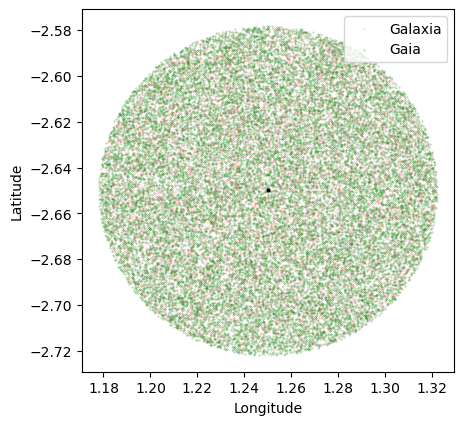

In [17]:
tab = Table.read(f'./Simulations/{date}_label.fits')
maglim = 20

plt.figure(figsize=(4.8,4.8), dpi=100)
taxarr = np.array(h5py.File(f'./Simulations/{date}.h5', 'r')['l0b0'])
romarr = np.array(h5py.File(f'./Simulations/{date}mod.h5', 'r')['l0b0'])
for herelb in tab['file_name'].data:
    if herelb != 'l0b0':
        taxarr = np.hstack([taxarr, h5py.File(f'./Simulations/{date}.h5', 'r')[herelb]])
        romarr = np.hstack([romarr, h5py.File(f'./Simulations/{date}mod.h5', 'r')[herelb]])
gyp = taxarr['ubv_V'] + 5 * np.log10(100 * taxarr['rad']) + taxarr['exbv'] * 2.742
plt.scatter(taxarr['glon'][np.where(gyp < maglim)[0]], taxarr['glat'][np.where(gyp < maglim)[0]], s=0.1, alpha=0.5, c='lightcoral', label='Galaxia')
plt.scatter(r['l'], r['b'], s=0.1, alpha=0.5, c='g', label='Gaia')
plt.scatter(1.25,-2.65,s=4, c='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right', scatterpoints=1)
plt.show()

In [14]:
len(r), len(romarr), len(taxarr)

(5146, 233540, 2930434)

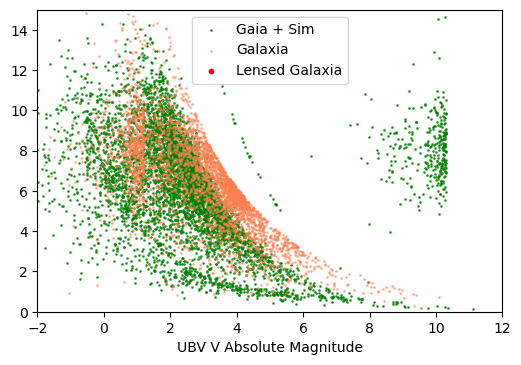

In [15]:
plt.figure(dpi=100)
plt.scatter(romarr['ubv_V'], romarr['rad'], alpha=0.7, s=1, c='g', label='Gaia + Sim')
plt.scatter(taxarr['ubv_V'][np.where(gyp < maglim)[0]], taxarr['rad'][np.where(gyp < maglim)[0]], alpha=0.5, s=1, c='coral', label='Galaxia')
plt.scatter(event_tab[np.where(event_tab['ubv_V_S'] + 5 * np.log10(100 * event_tab['rad_S']) + event_tab['exbv_S'] * 2.742 < maglim)[0]]['ubv_V_S'],
            event_tab[np.where(event_tab['ubv_V_S'] + 5 * np.log10(100 * event_tab['rad_S']) + event_tab['exbv_S'] * 2.742 < maglim)[0]]['rad_S'], 
            c='r', s=10, label='Lensed Galaxia')
plt.xlim(-2,12)
plt.ylim(0,15)
plt.xlabel('UBV V Absolute Magnitude')
plt.ylabel('Distance (kpc)')
plt.legend()
plt.show()

In [48]:
np.sum(~np.isnan(r['phot_g_mean_mag'])), len(r['phot_g_mean_mag']), np.sum(~np.isnan(r['distance_gspphot']))

(5122, 5146, 465)

--
--
--
18.362259
--
20.240196
--
--
--
--
--


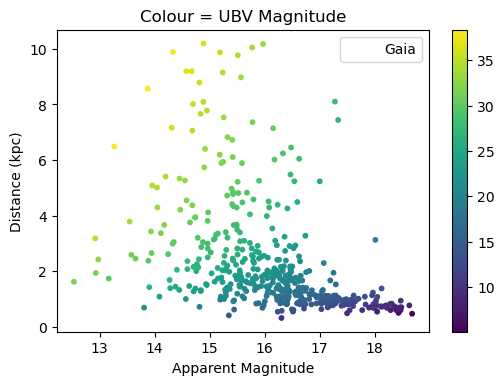

In [89]:
plt.figure(dpi=100)
plt.scatter(r['phot_g_mean_mag'], r['distance_gspphot']/1e3, alpha=1, 
            s=10, c=(12-(r['phot_g_mean_mag'] - 5 * np.log10(100 * r['distance_gspphot']/1e3)))*3, 
            label='Gaia', cmap=plt.cm.get_cmap('viridis'))
plt.colorbar()
plt.xlabel('Apparent Magnitude')
plt.ylabel('Distance (kpc)')
plt.title('Colour = UBV Magnitude')
plt.legend()
plt.show()

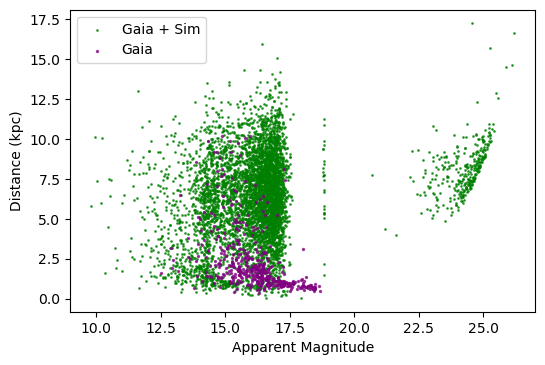

In [36]:
plt.figure(dpi=100)
plt.scatter(romarr['ubv_V']+5*np.log10(100*romarr['rad']+romarr['exbv']*2.742), romarr['rad'], alpha=0.7, 
            s=1, c='g', label='Gaia + Sim')
plt.scatter(r['phot_g_mean_mag'], r['distance_gspphot']/1e3, alpha=0.7, 
            s=2, c='purple', label='Gaia')
plt.xlabel('Apparent Magnitude')
plt.ylabel('Distance (kpc)')
plt.legend()
plt.show()

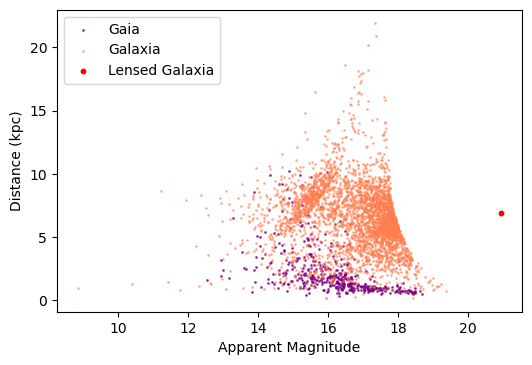

In [37]:
plt.figure(dpi=100)
# plt.scatter(romarr['ubv_V']+5*np.log10(100*romarr['rad']+romarr['exbv']*2.742), romarr['rad'], alpha=0.7, 
#             s=1, c='g', label='Gaia + Sim')
plt.scatter(r['phot_g_mean_mag'], r['distance_gspphot']/1e3, alpha=0.7, 
            s=1, c='purple', label='Gaia')
plt.scatter((taxarr['ubv_V']+5*np.log10(100*taxarr['rad']+taxarr['exbv']*2.742))[np.where(gyp < 20)[0]], 
             taxarr['rad'][np.where(gyp < 20)[0]], alpha=0.5, s=1, c='coral', label='Galaxia')
plt.scatter((event_tab['ubv_V_S'] + 5 * np.log10(100 * event_tab['rad_S']) 
                                + event_tab['exbv_S'] * 2.742)[np.where(event_tab['ubv_V_S'] 
                                + 5 * np.log10(100 * event_tab['rad_S']) + event_tab['exbv_S'] * 2.742 < 21)[0]],
             event_tab[np.where(event_tab['ubv_V_S'] + 5 * np.log10(100 * event_tab['rad_S']) 
                                + event_tab['exbv_S'] * 2.742 < 21)[0]]['rad_S'], 
            c='r', s=10, label='Lensed Galaxia')
#plt.xlim(-2,12)
#plt.ylim(0,15)
plt.xlabel('Apparent Magnitude')
plt.ylabel('Distance (kpc)')
plt.legend()
plt.show()

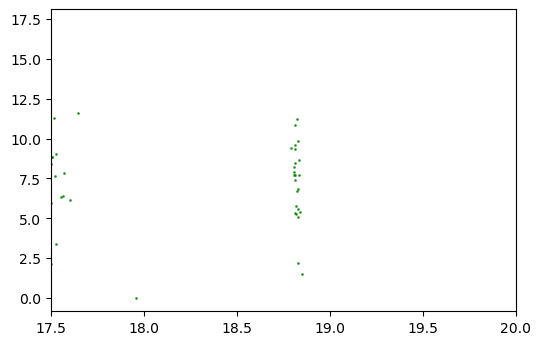

In [27]:
plt.figure(dpi=100)
tmp_romarr = romarr['ubv_V']+5*np.log10(100*romarr['rad']+romarr['exbv']*2.742)
plt.scatter(tmp_romarr, romarr['rad'], alpha=0.7, 
            s=1, c='g', label='Gaia + Sim')
plt.xlim([17.5,20]) # Some Gaia stars
# plt.xlim([20,28]) # Simulated white dwarfs
plt.show()

In [28]:
# Gaia stars
romarr[(tmp_romarr > 18) & (tmp_romarr < 20)]

array([(1., 1., 0., 0., 0., 0., 0., 0., 11., 0, 0.79970611, -2.64879444, 1.22590247, -5., 6., 3., 2.,  7.734694  ,  7, 3000506, 4.36499119, 4.36499119, 4.36499119, 4.36499119, 4.36499119, 4.36499119, 4.36499119, 4.36499119,  -17.61233521,   1.48066786, -14.62483127),
       (1., 1., 0., 0., 0., 0., 0., 0., 11., 0, 0.79970611, -2.63965082, 1.22292798, -5., 6., 3., 2.,  7.4283452 ,  7, 3000615, 4.45274639, 4.45274639, 4.45274639, 4.45274639, 4.45274639, 4.45274639, 4.45274639, 4.45274639,   98.42804718,  -0.33675198,   2.81636626),
       (1., 1., 0., 0., 0., 0., 0., 0., 11., 0, 0.80143485, -2.62551344, 1.22667616, -5., 6., 3., 2.,  8.19689655, 31, 3000849, 4.23421764, 4.23421764, 4.23421764, 4.23421764, 4.23421764, 4.23421764, 4.23421764, 4.23421764, -179.38685608,  37.17781168,  25.88682289),
       (1., 1., 0., 0., 0., 0., 0., 0., 11., 0, 0.80004537, -2.67194417, 1.24792558, -5., 6., 3., 2.,  5.35385847, 31, 3000924, 5.16294193, 5.16294193, 5.16294193, 5.16294193, 5.16294193, 5.162941

In [26]:
# Simulated white dwarfs
romarr[tmp_romarr > 20]

array([(1.29276708, 0.55051882,  8.20756885, 0.17591865, -0.38381002,  246.9783746 , -477.57174946, -110.24279214,  9.75746369, 5, 0.81577265, -2.67672883, 1.22791363, nan, nan, nan, nan,  8.21838465, 101, 2667548,  9.65556223,  9.76096155,  9.87661576, 7.50547621,  9.31829026,  8.62323441,  8.90773423,  9.0347464 ,  2.41577705e+02, -2.5410628 , -12.38258895),
       (1.29276708, 0.55051882,  8.20756885, 0.17591865, -0.38381002,  246.9783746 , -477.57174946, -110.24279214,  9.75746369, 5, 0.81577265, -2.67672883, 1.22791363, nan, nan, nan, nan,  8.21838465, 101, 2667548,  9.65556223,  9.76096155,  9.87661576, 7.50547621,  9.31829026,  8.62323441,  8.90773423,  9.0347464 ,  2.41577705e+02, -2.5410628 , -12.38258895),
       (1.293635  , 0.55068059,  5.85444479, 0.1254201 , -0.27209125,   -9.50535408, -128.38078837,   29.14010272,  9.75746369, 5, 0.73005855, -2.6603636 , 1.22722724, nan, nan, nan, nan,  5.86210498, 101, 2667727, 10.73289925, 10.80815487, 10.90373242, 9.03511748, 10.45728

In [20]:
event_tab[np.where(event_tab['ubv_V_S'] + 5 * np.log10(100 * event_tab['rad_S']) + event_tab['exbv_S'] * 2.742 < 21)[0]]

zams_mass_L,mass_L,px_L,py_L,pz_L,vx_L,vy_L,vz_L,age_L,popid_L,exbv_L,glat_L,glon_L,mbol_L,grav_L,teff_L,feh_L,rad_L,rem_id_L,obj_id_L,ubv_J_L,ubv_H_L,ubv_K_L,ubv_U_L,ubv_I_L,ubv_B_L,ubv_V_L,ubv_R_L,vr_L,mu_b_L,mu_lcosb_L,zams_mass_S,mass_S,px_S,py_S,pz_S,vx_S,vy_S,vz_S,age_S,popid_S,exbv_S,glat_S,glon_S,mbol_S,grav_S,teff_S,feh_S,rad_S,rem_id_S,obj_id_S,ubv_J_S,ubv_H_S,ubv_K_S,ubv_U_S,ubv_I_S,ubv_B_S,ubv_V_S,ubv_R_S,vr_S,mu_b_S,mu_lcosb_S,theta_E,u0,mu_rel,t0
float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.14048679172992706,0.14048679172992706,6.751564979553223,0.14656417071819305,-0.31050732731819153,36.234107971191406,-188.6861114501953,-42.21194839477539,10.0,9,0.7722296118736267,-2.6325836960742626,1.2436117555356572,-2.6172361373901367,5.152912616729736,3.502209186553955,0.09759803861379623,6.760326019561669,0,611335,9.451156616210938,8.90351676940918,8.65170669555664,17.02598762512207,10.802875518798828,15.25186824798584,13.568978309631348,12.316466331481934,34.03539633783982,-1.2688230576498645,-5.906732222841856,0.9795153141021729,0.9781149625778198,6.892256736755371,0.1496155560016632,-0.31697869300842285,-156.89166259765625,-171.16824340820312,-179.6239471435547,10.0,9,0.7772533893585205,-2.632583348904345,1.2436116820806207,0.09828217327594757,4.256204128265381,3.7450082302093506,0.29377317428588867,6.90114699784136,0,679099,3.369067907333374,3.002471923828125,2.9625394344329834,5.703638076782227,3.8345963954925537,5.380715370178223,4.612456798553467,4.185327053070068,-152.14974471775284,-5.706251140782595,-5.123163567243755,0.05868832939606825,1.0339018779290365,4.506078986326231,100.0


## Photometry

Photometric band for the observations and the reddening law.
The final file of microlensing events is produced here as a .fits file.

In [90]:
synthetic.refine_events(input_root = f'./Simulations/{date}', 
                        filter_name = 'V',
                        photometric_system = 'ubv',
                        red_law = 'Damineli16', 
                        input_time_array = -1, # input_time_array,
                        overwrite = False, 
                        output_file = 'default')

Original candidate events:  442
Candidate events in survey window:  386
refine_events runtime : 1.355524 s


In [ ]:
refined_event_tab = Table.read('./Simulations/20230325a/out_refined_events_ubv_V_Damineli16.fits')

In [ ]:
refined_event_tab[np.where(refined_event_tab['ubv_V_S'] + 5 * np.log10(100 * refined_event_tab['rad_S']) + refined_event_tab['exbv_S'] * 2.742 < 25)[0]]

## Things you can do with PopSyCLE

First, read in the table, and print out a list of all the possible keys:

In [ ]:
t = Table.read(f'./Simulations/{date}_refined_events_ubv_V_Damineli16.fits')
print(t.colnames)

In [ ]:
# Figure out how many events due to BH, NS, WD, star

bh_idx = np.where(t['rem_id_L'] == 103)[0]
ns_idx = np.where(t['rem_id_L'] == 102)[0]
wd_idx = np.where(t['rem_id_L'] == 101)[0]
st_idx = np.where(t['rem_id_L'] == 0)[0]
print('Number of BHs: ' + str(len(bh_idx)))
print('Number of NSs: ' + str(len(ns_idx)))
print('Number of WDs: ' + str(len(wd_idx)))
print('Number of stars: ' + str(len(st_idx)))

In [ ]:
# Histogram of tE

plt.hist(t['t_E'], bins = np.logspace(0, 2.5, 15))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')

In [ ]:
# piE vs tE

plt.scatter(t['t_E'], t['pi_E'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')
plt.ylabel('$\pi_E$')

In [ ]:
# dL vs dS

plt.scatter(t['rad_L'], t['rad_S'])
plt.xlabel('$d_L$ (kpc)')
plt.ylabel('$d_S$ (kpc)')